Using device: cuda:9
기존 괄호 매칭 데이터셋 불러오기...
Train 샘플 수: 8000
Test 샘플 수: 2000
예시 0: (()()(((()()())()(()))))()((()(((())(())))))(()(()))((())()(()()))()()()((()))()...  라벨:1
예시 1: (()(((((())((()()))((())())((((()()))(()(()))(())))))(())()))((((()(()))())())()...  라벨:0
예시 2: ()()()()()()((((()()((())(())(())()(()(()()(())(())((((())(()))())()(())))((((((...  라벨:1
MLP (OneHot) | Epoch 01 | Train Acc 0.5835 | Test Acc 0.6115
MLP (OneHot) | Epoch 02 | Train Acc 0.7114 | Test Acc 0.7425
MLP (OneHot) | Epoch 03 | Train Acc 0.7509 | Test Acc 0.7015
MLP (OneHot) | Epoch 04 | Train Acc 0.7699 | Test Acc 0.7645
MLP (OneHot) | Epoch 05 | Train Acc 0.7790 | Test Acc 0.7480
MLP (OneHot) | Epoch 06 | Train Acc 0.7956 | Test Acc 0.7485
MLP (OneHot) | Epoch 07 | Train Acc 0.8065 | Test Acc 0.7625
MLP (OneHot) | Epoch 08 | Train Acc 0.8123 | Test Acc 0.8390
MLP (OneHot) | Epoch 09 | Train Acc 0.8031 | Test Acc 0.7915
MLP (OneHot) | Epoch 10 | Train Acc 0.8183 | Test Acc 0.8675
MLP (OneHot) | Epoch 11 | 

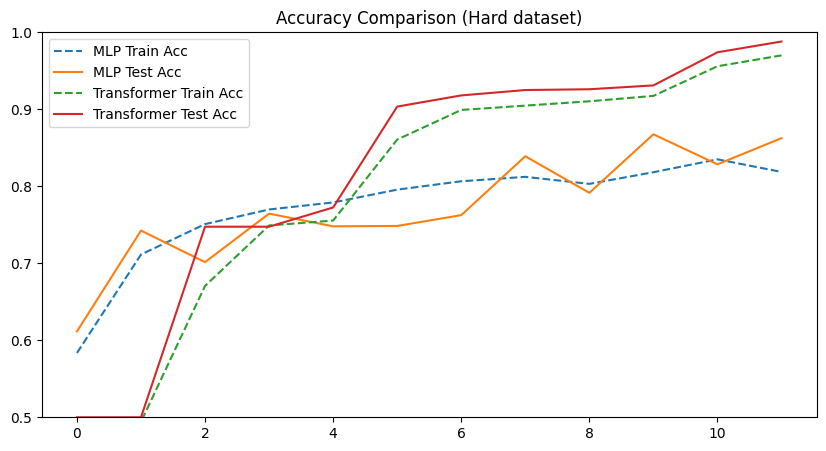


문자열: (()())
MLP (OneHot) 예측: Invalid (정답: Valid)
Transformer 예측: Invalid (정답: Valid)

문자열: ())(
MLP (OneHot) 예측: Invalid (정답: Invalid)
Transformer 예측: Invalid (정답: Invalid)

문자열: (((((())))))
MLP (OneHot) 예측: Invalid (정답: Valid)
Transformer 예측: Invalid (정답: Valid)

문자열: (()(()))())
MLP (OneHot) 예측: Invalid (정답: Invalid)
Transformer 예측: Invalid (정답: Invalid)

문자열: ((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((...
MLP (OneHot) 예측: Invalid (정답: Invalid)
Transformer 예측: Invalid (정답: Invalid)

문자열: )(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((...
MLP (OneHot) 예측: Invalid (정답: Invalid)
Transformer 예측: Invalid (정답: Invalid)


In [1]:
# ==============================
# 1. 라이브러리
# ==============================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import random, math, os
import matplotlib.pyplot as plt

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# GPU 9번 카드 고정
device = torch.device("cuda:9" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def check_valid(s): 
    stack = [] 
    for ch in s: 
        if ch == "(": 
            stack.append(ch) 
        else: 
            if not stack: 
                return 0 
            stack.pop() 
    return 1 if not stack else 0

def load_dataset(filename): 
    samples = [] 
    with open(filename, "r") as f: 
        for line in f: 
            s, lbl = line.strip().split("\t") 
            samples.append((s, int(lbl))) 
    
    return samples

# 파일 이름
train_file = "paren_train_extreme_fixed.txt"
test_file  = "paren_test_extreme_fixed.txt"

# 파일 불러오기 or 새로 생성
if os.path.exists(train_file) and os.path.exists(test_file):
    print("기존 괄호 매칭 데이터셋 불러오기...")
    train_samples = load_dataset(train_file)
    test_samples  = load_dataset(test_file)


print("Train 샘플 수:", len(train_samples))
print("Test 샘플 수:", len(test_samples))

# 몇 개 샘플 확인
for i in range(3):
    print(f"예시 {i}: {train_samples[i][0][:80]}...  라벨:{train_samples[i][1]}")

# ==============================
# 3. 토큰화 및 Vocab
# ==============================
vocab = {"<pad>":0, "<unk>":1, "(":2, ")":3}

def encode(s, max_len=400):
    ids = [vocab.get(ch, 1) for ch in s]
    if len(ids) < max_len:
        ids += [0]*(max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

def encode_onehot(s, max_len=400):
    ids = encode(s, max_len)
    onehot = torch.zeros(max_len, len(vocab))
    for i, idx in enumerate(ids):
        onehot[i, idx] = 1.0
    return onehot

class ParenDataset(Dataset):
    def __init__(self, samples, max_len=400, onehot=False):
        self.samples = samples
        self.max_len = max_len
        self.onehot = onehot
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        s, label = self.samples[idx]
        if self.onehot:
            x = encode_onehot(s, self.max_len)        # [L, V]
        else:
            x = torch.tensor(encode(s, self.max_len), dtype=torch.long)  # [L]
        return x, torch.tensor(label, dtype=torch.long)

# Loader 분리 (최대 길이 400)
train_ds_mlp   = ParenDataset(train_samples, max_len=400, onehot=True)
test_ds_mlp    = ParenDataset(test_samples,  max_len=400, onehot=True)
train_loader_mlp = DataLoader(train_ds_mlp, batch_size=64, shuffle=True)
test_loader_mlp  = DataLoader(test_ds_mlp,  batch_size=64)

train_ds_trans = ParenDataset(train_samples, max_len=400, onehot=False)
test_ds_trans  = ParenDataset(test_samples,  max_len=400, onehot=False)
train_loader_trans = DataLoader(train_ds_trans, batch_size=64, shuffle=True)
test_loader_trans  = DataLoader(test_ds_trans,  batch_size=64)

# ==============================
# 4. Positional Encoding
# ==============================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=4096):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)   # [1, max_len, d_model]
        self.register_buffer("pe", pe)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# ==============================
# 5. Transformer Classifier
# ==============================
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, nhead=4, hidden_dim=256, num_layers=2, num_classes=2, max_len=400):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.pos_encoder = PositionalEncoding(emb_dim, max_len=max_len)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim, nhead=nhead, dim_feedforward=hidden_dim, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.fc = nn.Linear(emb_dim, num_classes)
    def forward(self, x):
        emb = self.embedding(x)          # [B, L] -> [B, L, D]
        emb = self.pos_encoder(emb)      # + PE
        out = self.encoder(emb)          # [B, L, D]
        out = out.mean(dim=1)            # mean-pool
        return self.fc(out)              # [B, 2]

# ==============================
# 6. MLP Classifier (원핫 입력)
# ==============================
class MLPClassifier(nn.Module):
    def __init__(self, input_len=400, vocab_size=4, hidden_dim=96, num_classes=2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_len * vocab_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self, x):
        return self.fc(x)  # [B, L, V] 원핫 -> [B, 2]

# ==============================
# 7. 학습 함수
# ==============================
def train_model(model, train_loader, test_loader, epochs=12, lr=1e-3, name="Model"):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_accs, test_accs = [], []
    for epoch in range(epochs):
        # train
        model.train()
        total_correct = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            total_correct += (pred.argmax(1) == y).sum().item()
        train_acc = total_correct / len(train_loader.dataset)

        # eval
        model.eval()
        total_correct = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                total_correct += (pred.argmax(1) == y).sum().item()
        test_acc = total_correct / len(test_loader.dataset)

        train_accs.append(train_acc)
        test_accs.append(test_acc)
        print(f"{name} | Epoch {epoch+1:02d} | Train Acc {train_acc:.4f} | Test Acc {test_acc:.4f}")
    return train_accs, test_accs

# ==============================
# 8. 학습 실행
# ==============================
mlp = MLPClassifier(input_len=400, vocab_size=len(vocab))
mlp_train_accs, mlp_test_accs = train_model(mlp, train_loader_mlp, test_loader_mlp, epochs=12, name="MLP (OneHot)")

trans = TransformerClassifier(len(vocab), max_len=400)
trans_train_accs, trans_test_accs = train_model(trans, train_loader_trans, test_loader_trans, epochs=12, name="Transformer")

# ==============================
# 9. 학습 곡선 비교
# ==============================
plt.figure(figsize=(10,5))
plt.plot(mlp_train_accs, label="MLP Train Acc", linestyle="--")
plt.plot(mlp_test_accs, label="MLP Test Acc")
plt.plot(trans_train_accs, label="Transformer Train Acc", linestyle="--")
plt.plot(trans_test_accs, label="Transformer Test Acc")
plt.legend(); plt.title("Accuracy Comparison (Hard dataset)")
plt.ylim(0.5, 1.0)
plt.show()

# ==============================
# 10. 임의 입력 테스트
# ==============================
def predict_model(model, s, name="Model", onehot=False):
    model.eval()
    if onehot:
        ids = encode_onehot(s, max_len=400).unsqueeze(0).to(device)
    else:
        ids = torch.tensor(encode(s, max_len=400), dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(ids)
    label = pred.argmax(1).item()
    return f"{name} 예측: {'Valid' if label==1 else 'Invalid'} (정답: {'Valid' if check_valid(s) else 'Invalid'})"

test_strs = [
    "(()())", "())(", "(((((())))))", "(()(()))())",
    "(" * 200 + ")" * 199 + "(",                 # late-break
    ")" + "(" * 199 + ")" * 200,                 # prefix-break
]
for s in test_strs:
    print("\n문자열:", s[:80] + ("..." if len(s) > 80 else ""))
    print(predict_model(mlp, s, "MLP (OneHot)", onehot=True))
    print(predict_model(trans, s, "Transformer", onehot=False))
